# Data Preprocessing

#### Imports

In [1]:
import os
import re
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.offline as pyo
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Data Paths

In [2]:
raw_data_directory = 'data'
raw_data_path = 'data/product_info.csv'
processed_data_directory = 'processed_data'
processed_data_path = processed_data_directory + '/skincare.csv'

## Data Cleaning and Preprocessing

In [7]:
# Read all products info
df = pd.read_csv(raw_data_path)

# Filter df for rows where 'primary_category' is 'Skincare'
skincare_df = df[df['primary_category'] == 'Skincare']
print("Skin care data size:", len(skincare_df))

# Remove rows where highlight are non existent
skincare_df = skincare_df[skincare_df['highlights'].notna() & (skincare_df['highlights'] != '')]
print("Skin care data size after removing empty highlights:",len(skincare_df))

# Remove rows where ingredients are non existent
skincare_df = skincare_df[skincare_df['ingredients'].notna() & (skincare_df['ingredients'] != '')]
print("Skin care data size after removing empty ingredients:",len(skincare_df))

# Remove 'Mini' size products from data as it could be seen as a duplicate
skincare_df = skincare_df[~skincare_df['product_name'].str.contains('mini', case=False, na=False)]
# Also removing additional products with 'Mini Size' as their secondary category
skincare_df = skincare_df[skincare_df['secondary_category'] != 'Mini Size']
print(f"Size of skincare data after removing 'mini' from product names (case-insensitive): {len(skincare_df)}")

# Remove 'Limited edition' from data
skincare_df = skincare_df[~skincare_df['product_name'].str.contains('limited edition', case=False, na=False)]
print(f"Size of skincare data after removing 'limited edition' from product names (case-insensitive): {len(skincare_df)}")

# Remove 'Value & Gift Sets' from data to focus on individual products
skincare_df = skincare_df[skincare_df['secondary_category'] != 'Value & Gift Sets']
print("Skin care data size after removing 'Value & Gift Sets' secondary_category:",len(skincare_df))

# Clean highlight column
highlights = skincare_df['highlights']
highlights = [h.replace("[", "").replace("]", "").replace("'", "").replace("Best for ", "").replace("Good for: ", "").replace(" Skin", "").replace("/", ", ") for h in highlights]
skincare_df['highlights'] = highlights

# Function to clean each ingredient row
def clean_ingredients(row):
   # Replace unwanted characters
   row = row.replace("[", "").replace("]", "").replace("'", "").replace(" (Vegan)*", "").replace(".", "")
   
   # Remove text inside parentheses
   row = re.sub(r'\([^)]*\)', '', row)
   
   # Replace " , " with a single comma (in case extra spaces after commas)
   row = row.replace(" ,", ",")
   row = row.replace("  ", " ")
   
   # Check for "water", "aqua", or "eau" and replace first occurrence
   if "water" in row.lower() or "aqua" in row.lower() or "eau" in row.lower():
      row_list = row.split(", ")
      # Find the first occurrence of "water", "aqua", or "eau"
      index = next((i for i, s in enumerate(row_list) if 'water' in s.lower() or "aqua" in s.lower() or "eau" in s.lower()), -1)
      if index != -1:
         # Replace the identified word with "Water"
         row_list[index] = "Water"
      row = ", ".join(row_list)
   
   return row

# Apply the clean_ingredients function
skincare_df['ingredients'] = skincare_df['ingredients'].apply(clean_ingredients)

# Ensure the directory exists
output_dir = os.path.dirname(processed_data_path)
if not os.path.exists(output_dir):
   os.makedirs(output_dir)
# Save cleaned file
skincare_df.to_csv(processed_data_path, index=False)

Skin care data size: 2420
Skin care data size after removing empty highlights: 2003
Skin care data size after removing empty ingredients: 1927
Size of skincare data after removing 'mini' from product names (case-insensitive): 1743
Size of skincare data after removing 'limited edition' from product names (case-insensitive): 1741
Skin care data size after removing 'Value & Gift Sets' secondary_category: 1583


## Clean and Filter Product Reviews

In [9]:
# Convert product_id column to a set for efficient filtering
product_ids = set(skincare_df['product_id'])

def clean_reviews(raw_data_path, processed_data_path):
    """
    Clean the reviews in the given CSV file by filtering based on the conditions.
    - Filters rows where 'product_id' is in the skincare dataset.
    - Keeps reviews with rating 5, 4, and only 3-star reviews if they have review text.
    """
    try:
        # Read the data
        df = pd.read_csv(raw_data_path)

        # Keep only the filtered skincare data
        df = df[df['product_id'].isin(product_ids)]

        # # Check for 3-star reviews with no text or empty text
        # three_star_reviews = df[df['rating'] == 3]
        # no_text_reviews = three_star_reviews[three_star_reviews['review_text'].isna() | (three_star_reviews['review_text'].str.strip() == '')]

        # Keep reviews with rating 5, 4, or 3 (only keep 3-star reviews if they have review text)
        df = df[
            (df['rating'].isin((5, 4))) |
            ((df['rating'] == 3) & df['review_text'].notna() & (df['review_text'].str.strip() != ""))  # Include 3-star reviews only if they have text
        ]

        # Ensure the output directory exists
        output_dir = os.path.dirname(processed_data_path)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Save the cleaned file
        df.to_csv(processed_data_path, index=False)
        print(f"Processed and saved: {processed_data_path}")
    
    except Exception as e:
        print(f"Error processing {raw_data_path}: {e}")

# Apply the function to each review data file
clean_reviews('data/reviews_0-250.csv', 'processed_data/reviews_0-250.csv')
clean_reviews('data/reviews_250-500.csv', 'processed_data/reviews_250-500.csv')
clean_reviews('data/reviews_500-750.csv', 'processed_data/reviews_500-750.csv')
clean_reviews('data/reviews_750-1250.csv', 'processed_data/reviews_750-1250.csv')
clean_reviews('data/reviews_1250-end.csv', 'processed_data/reviews_1250-end.csv')

print("All files have been processed and saved.")

C:\Users\Ana Marija Pavičić\AppData\Local\Temp\ipykernel_11576\566355813.py:12: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



Processed and saved: processed_data/reviews_0-250.csv
Processed and saved: processed_data/reviews_250-500.csv
Processed and saved: processed_data/reviews_500-750.csv


C:\Users\Ana Marija Pavičić\AppData\Local\Temp\ipykernel_11576\566355813.py:12: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



Processed and saved: processed_data/reviews_750-1250.csv


C:\Users\Ana Marija Pavičić\AppData\Local\Temp\ipykernel_11576\566355813.py:12: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



Processed and saved: processed_data/reviews_1250-end.csv
All files have been processed and saved.


## Combining all reviews files into a single dataframe

In [10]:
# List of file paths for the processed reviews
file_paths = [
    'processed_data/reviews_0-250.csv',
    'processed_data/reviews_250-500.csv',
    'processed_data/reviews_500-750.csv',
    'processed_data/reviews_750-1250.csv',
    'processed_data/reviews_1250-end.csv'
]

# Combine all files into one DataFrame
combined_reviews_df = pd.DataFrame()

for file_path in file_paths:
    try:
        # Read each processed file with updated argument for handling bad lines
        df = pd.read_csv(file_path, 
                         on_bad_lines='skip',  # Skip bad lines instead of using deprecated arguments
                         encoding='utf-8',  # Ensure proper encoding
                         engine='python')  # Use Python engine for more robust handling
        
        # Append it to the combined DataFrame
        combined_reviews_df = pd.concat([combined_reviews_df, df], ignore_index=True)
        print(f"Successfully added {file_path}")
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Save the combined DataFrame to a single CSV file
output_combined_path = 'processed_data/combined_reviews.csv'
combined_reviews_df.to_csv(output_combined_path, index=False)
print(f"All files have been combined and saved to: {output_combined_path}")

Successfully added processed_data/reviews_0-250.csv
Successfully added processed_data/reviews_250-500.csv
Successfully added processed_data/reviews_500-750.csv
Successfully added processed_data/reviews_750-1250.csv
Successfully added processed_data/reviews_1250-end.csv
All files have been combined and saved to: processed_data/combined_reviews.csv


## Exploratory Data Analysis (EDA)

### Overall data overview

#### Skincare data

In [11]:
# Display the first few rows to get a sense of the data
print("Skincare Data Overview:")
print(skincare_df.head())

Skincare Data Overview:
   product_id                                       product_name  brand_id  \
89    P439055               GENIUS Sleeping Collagen Moisturizer      6018   
90    P421277                       GENIUS Liquid Collagen Serum      6018   
92    P432045               GENIUS Liquid Collagen Lip Treatment      6018   
93    P311143  SUBLIME DEFENSE Ultra Lightweight UV Defense F...      6018   
94    P384537                   GENIUS Ultimate Anti-Aging Cream      6018   

   brand_name  loves_count  rating  reviews           size variation_type  \
89   Algenist        33910  4.5413   1321.0    2 oz/ 60 mL           Size   
90   Algenist        67870  4.0259   1159.0  1 oz  / 30 mL           Size   
92   Algenist        44448  3.8721    649.0  .5 oz / 15 mL           Size   
93   Algenist        27278  4.4134    508.0           1 oz           Size   
94   Algenist        19733  4.2525    503.0    2 oz/ 60 mL           Size   

   variation_value  ... online_only out_of_s

In [12]:
# Get general info 
print("\nSkincare Data Info:")
print(skincare_df.info())


Skincare Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1583 entries, 89 to 8423
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          1583 non-null   object 
 1   product_name        1583 non-null   object 
 2   brand_id            1583 non-null   int64  
 3   brand_name          1583 non-null   object 
 4   loves_count         1583 non-null   int64  
 5   rating              1550 non-null   float64
 6   reviews             1550 non-null   float64
 7   size                1525 non-null   object 
 8   variation_type      1506 non-null   object 
 9   variation_value     1478 non-null   object 
 10  variation_desc      7 non-null      object 
 11  ingredients         1583 non-null   object 
 12  price_usd           1583 non-null   float64
 13  value_price_usd     17 non-null     float64
 14  sale_price_usd      17 non-null     float64
 15  limited_edition     1583 non-null   in

In [13]:
# Describe numerical columns for basic statistics
print("\nSkincare Data Statistics:")
print(skincare_df.describe())


Skincare Data Statistics:
          brand_id   loves_count       rating       reviews    price_usd  \
count  1583.000000  1.583000e+03  1550.000000   1550.000000  1583.000000   
mean   5676.037903  3.286060e+04     4.291681    529.062581    61.408149   
std    1421.601813  6.625197e+04     0.418085    936.350434    58.640613   
min    1063.000000  0.000000e+00     1.000000      1.000000     3.000000   
25%    5668.000000  4.284000e+03     4.095425     65.000000    30.000000   
50%    6195.000000  1.191200e+04     4.363600    227.500000    46.000000   
75%    6327.000000  3.440700e+04     4.569575    562.000000    71.000000   
max    8017.000000  1.081315e+06     5.000000  16118.000000   495.000000   

       value_price_usd  sale_price_usd  limited_edition          new  \
count        17.000000       17.000000      1583.000000  1583.000000   
mean        199.176471       18.205882         0.007581     0.078964   
std         184.000080       20.898609         0.086763     0.269768   


#### Product Reviews Data

In [14]:
# Display the first few rows to get a sense of the data
print("\nReview Data Overview:")
print(combined_reviews_df.head())


Review Data Overview:
   Unnamed: 0    author_id  rating  is_recommended  helpfulness  \
0           0   1741593524       5             1.0          1.0   
1           2   5061282401       5             1.0          NaN   
2           3   6083038851       5             1.0          NaN   
3           4  47056667835       5             1.0          NaN   
4           5  42802569154       4             1.0          1.0   

   total_feedback_count  total_neg_feedback_count  total_pos_feedback_count  \
0                     2                         0                         2   
1                     0                         0                         0   
2                     0                         0                         0   
3                     0                         0                         0   
4                     1                         0                         1   

  submission_time                                        review_text  \
0      2023-02-01  I use th

In [15]:
# Get general info 
print("\nReview Data Info:")
print(combined_reviews_df.info())


Review Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739955 entries, 0 to 739954
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                739955 non-null  int64  
 1   author_id                 739955 non-null  object 
 2   rating                    739955 non-null  int64  
 3   is_recommended            633266 non-null  float64
 4   helpfulness               331066 non-null  float64
 5   total_feedback_count      739955 non-null  int64  
 6   total_neg_feedback_count  739955 non-null  int64  
 7   total_pos_feedback_count  739955 non-null  int64  
 8   submission_time           739955 non-null  object 
 9   review_text               739027 non-null  object 
 10  review_title              526439 non-null  object 
 11  skin_tone                 627748 non-null  object 
 12  eye_color                 606040 non-null  object 
 13  skin_type                

In [16]:
# Describe numerical columns for basic statistics
print("\nReview Data Statistics:")
print(combined_reviews_df.describe())


Review Data Statistics:
          Unnamed: 0         rating  is_recommended    helpfulness  \
count  739955.000000  739955.000000   633266.000000  331066.000000   
mean   200664.227414       4.631782        0.938369       0.787738   
std    177291.951540       0.629846        0.240485       0.317060   
min         0.000000       3.000000        0.000000       0.000000   
25%     54855.000000       4.000000        1.000000       0.666667   
50%    131205.000000       5.000000        1.000000       1.000000   
75%    344118.500000       5.000000        1.000000       1.000000   
max    600987.000000       5.000000        1.000000       1.000000   

       total_feedback_count  total_neg_feedback_count  \
count         739955.000000             739955.000000   
mean               3.436651                  0.572193   
std               21.561642                  3.871098   
min                0.000000                  0.000000   
25%                0.000000                  0.000000   
50

### Distribution of categorical and numerical features

#### Skincare data


Skincare Secondary Categories Distribution:
secondary_category
Moisturizers              432
Treatments                395
Cleansers                 270
Eye Care                  146
Masks                     117
Sunscreen                  80
Lip Balms & Treatments     46
Self Tanners               42
Wellness                   34
High Tech Tools            21
Name: count, dtype: int64


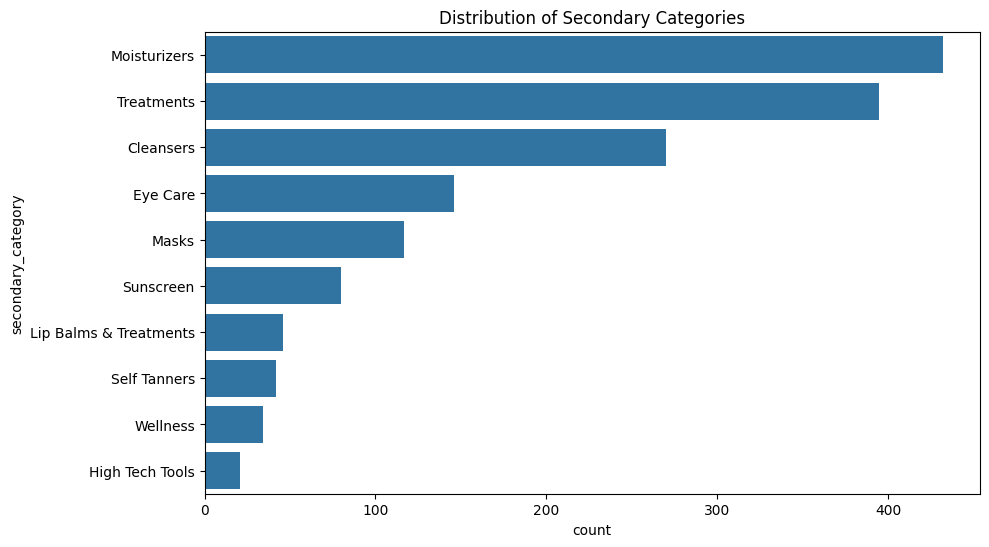

In [17]:
# Check distribution of secondary categories
print("\nSkincare Secondary Categories Distribution:")
secondary_category_counts = skincare_df['secondary_category'].value_counts().sort_values(ascending=False)
print(secondary_category_counts)

# Plot the distribution of secondary categories
plt.figure(figsize=(10,6))
sns.countplot(
    y='secondary_category', 
    data=skincare_df, 
    order=secondary_category_counts.index  # Sort the plot by frequency
)
plt.title('Distribution of Secondary Categories')
plt.show()

                Brand  Counts  Percent
0  SEPHORA COLLECTION      56     3.54
1        The Ordinary      39     2.46
2      The INKEY List      37     2.34
3      Paula's Choice      34     2.15
4               fresh      32     2.02
5   Peter Thomas Roth      31     1.96
6   Dr. Barbara Sturm      31     1.96
7            Shiseido      30     1.90
8            Caudalie      30     1.90
9  Kiehl's Since 1851      30     1.90


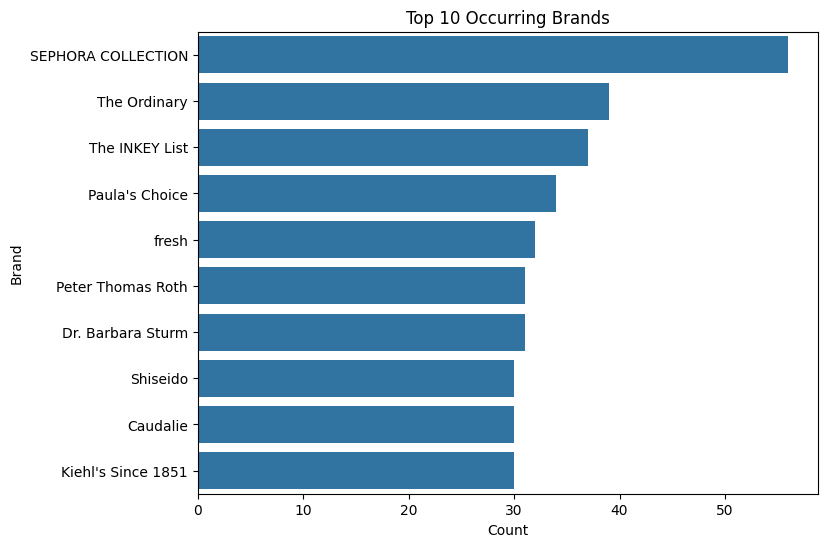

In [18]:
# Get the count and percentage of top brands
brand_count = skincare_df['brand_name'].value_counts()
brand_percentage = skincare_df['brand_name'].value_counts(normalize=True) * 100

# Create a DataFrame for the top brands
brand_df = pd.DataFrame({'Brand': brand_count.index, 'Counts': brand_count.values, 'Percent': np.round(brand_percentage.values, 2)})

# Display the top 10 brands
print(brand_df.head(10))

# Plot the top 10 brands horizontally
plt.figure(figsize=(8, 6))
sns.barplot(x='Counts', y='Brand', data=brand_df.head(10))
plt.xlabel('Count')
plt.title('Top 10 Occurring Brands')
plt.show()

#### Product Reviews Data


Review Ratings Distribution:
rating
5    528193
4    151059
3     60703
Name: count, dtype: int64


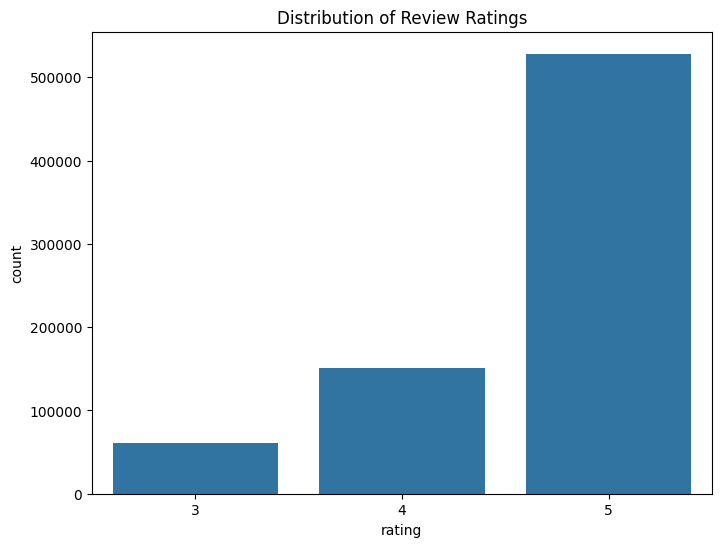

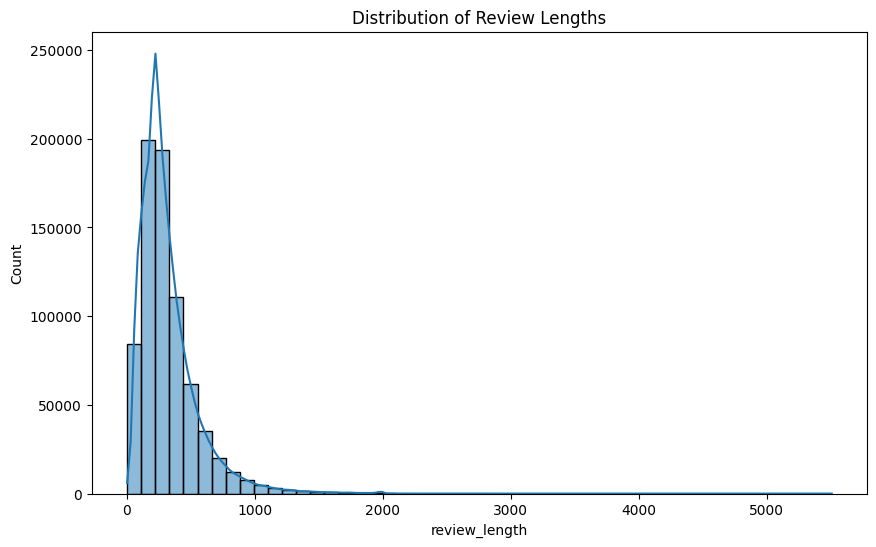

In [19]:
# Review rating distribution
print("\nReview Ratings Distribution:")
print(combined_reviews_df['rating'].value_counts())

# Plot the rating distribution
plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=combined_reviews_df)
plt.title('Distribution of Review Ratings')
plt.show()

# Review length (characters in review text)
combined_reviews_df['review_length'] = combined_reviews_df['review_text'].apply(lambda x: len(str(x)))

# Plot distribution of review lengths
plt.figure(figsize=(10,6))
sns.histplot(combined_reviews_df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.show()